In [4]:
import torch
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import time

%matplotlib inline

### 导入数据

In [5]:
data_dir = './data/DogsVSCats'
# 定义要对数据进行的处理
data_transform = {x: transforms.Compose([transforms.Resize([84, 84]),
                  transforms.ToTensor()])
                  for x in ["train", "valid"]}
# 数据载入
image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x), 
                                         transform=data_transform[x])
                 for x in ["train", "valid"]}
# 数据装载
dataloader = {x: torch.utils.data.DataLoader(dataset=image_datasets[x], 
                                            batch_size=16,
                                            shuffle=True)
             for x in ["train", "valid"]}


### 数据预览

In [6]:
X_example, y_example = next(iter(dataloader["train"]))
print(u'X_example个数{}'.format(len(X_example)))
print(u'y_example个数{}'.format(len(y_example)))
print(X_example.shape)
print(y_example.shape)

X_example个数16
y_example个数16
torch.Size([16, 3, 84, 84])
torch.Size([16])


In [7]:
index_classes = image_datasets["train"].class_to_idx
print(index_classes)

{'cat': 0, 'dog': 1}


In [8]:
example_classes = image_datasets["train"].classes
print(example_classes)

['cat', 'dog']


cat   dog   cat   cat   cat   cat   cat   dog   
cat   dog   dog   cat   cat   cat   cat   dog   


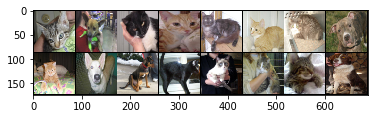

In [9]:
img = torchvision.utils.make_grid(X_example)
img = img.numpy().transpose([1, 2, 0])

for i in range(len(y_example)):
    index = y_example[i]
    print(example_classes[index], end='   ')
    if (i+1)%8 == 0:
        print()
plt.imshow(img)
plt.show()

### 搭建一个VGG模型

In [10]:
# 创建模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 18 * 18, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


net = Net()

NameError: name 'nn' is not defined

In [11]:
loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    
epoch_n = 10
time_open = time.time()

for epoch in range(epoch_n):
    print("Epoch {}/{}".format(epoch+1, epoch_n))
    print("-"*10)
    
    for phase in ["train", "valid"]:
        if phase == "train":
            print("Training...")
            # 设置为True，会进行Dropout并使用batch mean和batch var
            model.train(True)
        else:
            print("Validing...")
             # 设置为False，不会进行Dropout并使用running mean和running var
            model.train(False)
            
        running_loss = 0.0
        running_corrects = 0
        
        n = 0
        # enuerate(),返回的是索引和元素值，数字1表明设置start=1，即索引值从1开始
        for batch, data in enumerate(dataloader[phase], 1):
            # X: 图片，16*3*64*64; y: 标签，16
            n += 1
            X, y = data                
            print(X.shape)
            print(y)
            
            # 封装成Variable类
            X, y = Variable(X), Variable(y)
            
            # ************************
            for i in range(10):
                y_pred = model(X)
                
                _, pred = torch.max(y_pred.data, 1)
                
                optimizer.zero_grad()
                loss = loss_f(y_pred, y)
#                 print(y_pred)
                
                loss.backward()
                optimizer.step()
                print(loss)
            # ************************
            break
            
            # y_pred: 预测概率矩阵，16*2
            y_pred = model(X)
            
            # pred，概率较大值对应的索引值，可看做预测结果
            _, pred = torch.max(y_pred.data, 1)
            
            # 梯度归零
            optimizer.zero_grad()
            
            # 计算损失
            loss = loss_f(y_pred, y)
            print(loss)
            # 若是在进行模型训练，则需要进行后向传播及梯度更新
            if phase == "train":
                loss.backward()
                optimizer.step()
            
            # 计算损失和
            running_loss += loss
            if n == 2:
                break
            # 统计预测正确的图片数
            running_corrects += torch.sum(pred==y.data)
            
            # 共20000张测试图片，1250个batch，在使用500个及1000个batch对模型进行训练之后，输出训练结果
            if batch%10==0 and phase=="train":
                print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4F}%".format(batch, running_loss/batch, 
                                                                              100*running_corrects/(16*batch)))
              
        epoch_loss = running_loss * 16 / len(image_datasets[phase])
        epoch_acc = 100 * running_corrects / len(image_datasets[phase])
        break 
        # 输出最终的结果
        print("{} Loss:{:.4f} Acc:{:.4f}%".format(phase, epoch_loss, epoch_acc))
    break

NameError: name 'model' is not defined